In [111]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# read Excel file
df = pd.read_excel('stopwords.xlsx')

# extract words from cells and convert to list
words = df.values.flatten().tolist()

words = [x for x in words if str(x) != 'nan']

#print(words)

new_words = []

for word in words:
    if "'" in word:
        new_word = word.replace("'", "")
        new_words.append(new_word)
    new_words.append(word)

# print the list of words
print(len(words))
print(len(new_words))

664
690


In [19]:
stopwords_df = pd.DataFrame({"stopwords":new_words})
stopwords_df.to_csv('stopwords.csv', index=False)

In [53]:
stopwords_df = pd.read_csv('Datasets/scraped/stopwords.csv')
script_df = pd.read_csv('Datasets/data-society-the-simpsons-by-the-data/simpsons_script_lines.csv')
characters_df = pd.read_csv('Datasets/data-society-the-simpsons-by-the-data/simpsons_characters.csv')
script_df['character_id'] = script_df['character_id'].fillna(0).astype(int)

C:\Users\nikol\AppData\Local\Temp\ipykernel_16032\1098175798.py:2: DtypeWarning: Columns (4,5,26) have mixed types. Specify dtype option on import or set low_memory=False.
  script_df = pd.read_csv('Datasets/data-society-the-simpsons-by-the-data/simpsons_script_lines.csv')


In [96]:
script_df.iloc[153016]

id                                                                 4263
episode_id                                                           14
number                                                              255
raw_text              Entire Town: "GONE AWAY IS THE BLUEBIRD / HERE...
timestamp_in_ms                                                 1141000
speaking_line                                                      TRUE
character_id                                                        241
location_id                                                       211.0
raw_character_text                                          Entire Town
raw_location_text                                          NEIGHBORHOOD
spoken_words          GONE AWAY IS THE BLUEBIRD / HERE TO STAY...,go...
normalized_text        WITH HEART) ""Chapter Six: Four Days in Phila...
word_count                                                    1154000.0
Unnamed: 13                                                     

In [87]:
script_df.head()

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,...,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,True,464,3.0,Miss Hoover,Springfield Elementary School,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,True,9,3.0,Lisa Simpson,Springfield Elementary School,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,True,464,3.0,Miss Hoover,Springfield Elementary School,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9552,32,212,Lisa Simpson: That life is worth living.,864000,True,9,3.0,Lisa Simpson,Springfield Elementary School,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9553,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,True,40,3.0,Edna Krabappel-Flanders,Springfield Elementary School,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [157]:
character_lines = []
for i in range(10):
    sep_lines = script_df.loc[script_df['character_id']==i]['raw_text'].tolist()
    sep_lines = [x for x in sep_lines if str(x) != 'nan']
    total_lines = ''.join(sep_lines)
    character_lines.append(total_lines)

In [153]:
vectorizer = TfidfVectorizer(stop_words=stopwords_df['stopwords'].tolist(),
                             lowercase=True, min_df=0.05, max_df=0.95)
tf_idf_matrix = vectorizer.fit_transform(character_lines)
feature_names = vectorizer.get_feature_names_out()

D:\Documents\Programming\datamadness\venv\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['al', 'didn', 'doesn', 'don', 'hasn', 'haven', 'isn', 'shouldn'] not in stop_words.
  warnings.warn(


In [155]:
feature_scores = tf_idf_matrix[3].toarray().tolist()[0]
feature_dict = dict(zip(feature_names, feature_scores))
top_k_features = sorted(feature_dict.items(), key=lambda x: x[1], reverse=True)[:10]
top_k_keywords = [feature[0] for feature in top_k_features]
print(top_k_keywords)

['seymour', 'skinner', 'bart', 'school', 'uh', 'mother', 'will', 'simpson', 'don', 'lisa']


In [109]:

def extract_top_k_keywords(character_id, k):
    #print(characters_df.loc[characters_df['id']==character_id]['name'])
    #text_list = script_df.loc[script_df['character_id']==character_id]['raw_text'].tolist()
    #text_list = [x for x in text_list if str(x) != 'nan']
    vectorizer = TfidfVectorizer(stop_words=stopwords_df['stopwords'].tolist(), lowercase=True, min_df=0.05, max_df=0.95)
    tf_idf_matrix = vectorizer.fit_transform(character_lines)
    feature_names = vectorizer.get_feature_names_out()

    # Get the average tf-idf score for each feature across all documents
    feature_scores = tf_idf_matrix.mean(axis=0).tolist()[0]

    # Create a dictionary mapping feature names to their tf-idf scores
    feature_dict = dict(zip(feature_names, feature_scores))

    # Sort the features by tf-idf score and return the top k features
    top_k_features = sorted(feature_dict.items(), key=lambda x: x[1], reverse=True)[:k]

    # Extract the feature names from the top k features and return them as a list
    top_k_keywords = [feature[0] for feature in top_k_features]

    return top_k_keywords

In [110]:
extract_top_k_keywords(2, 10)

D:\Documents\Programming\datamadness\venv\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['al', 'didn', 'doesn', 'don', 'hasn', 'haven', 'isn', 'shouldn'] not in stop_words.
  warnings.warn(


['simpson',
 'lisa',
 'janey',
 'bart',
 'marge',
 'homer',
 'dewey',
 'seymour',
 'todd',
 'skinner']

D:\Documents\Programming\datamadness\venv\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['al', 'didn', 'doesn', 'don', 'hasn', 'haven', 'isn', 'shouldn'] not in stop_words.
  warnings.warn(


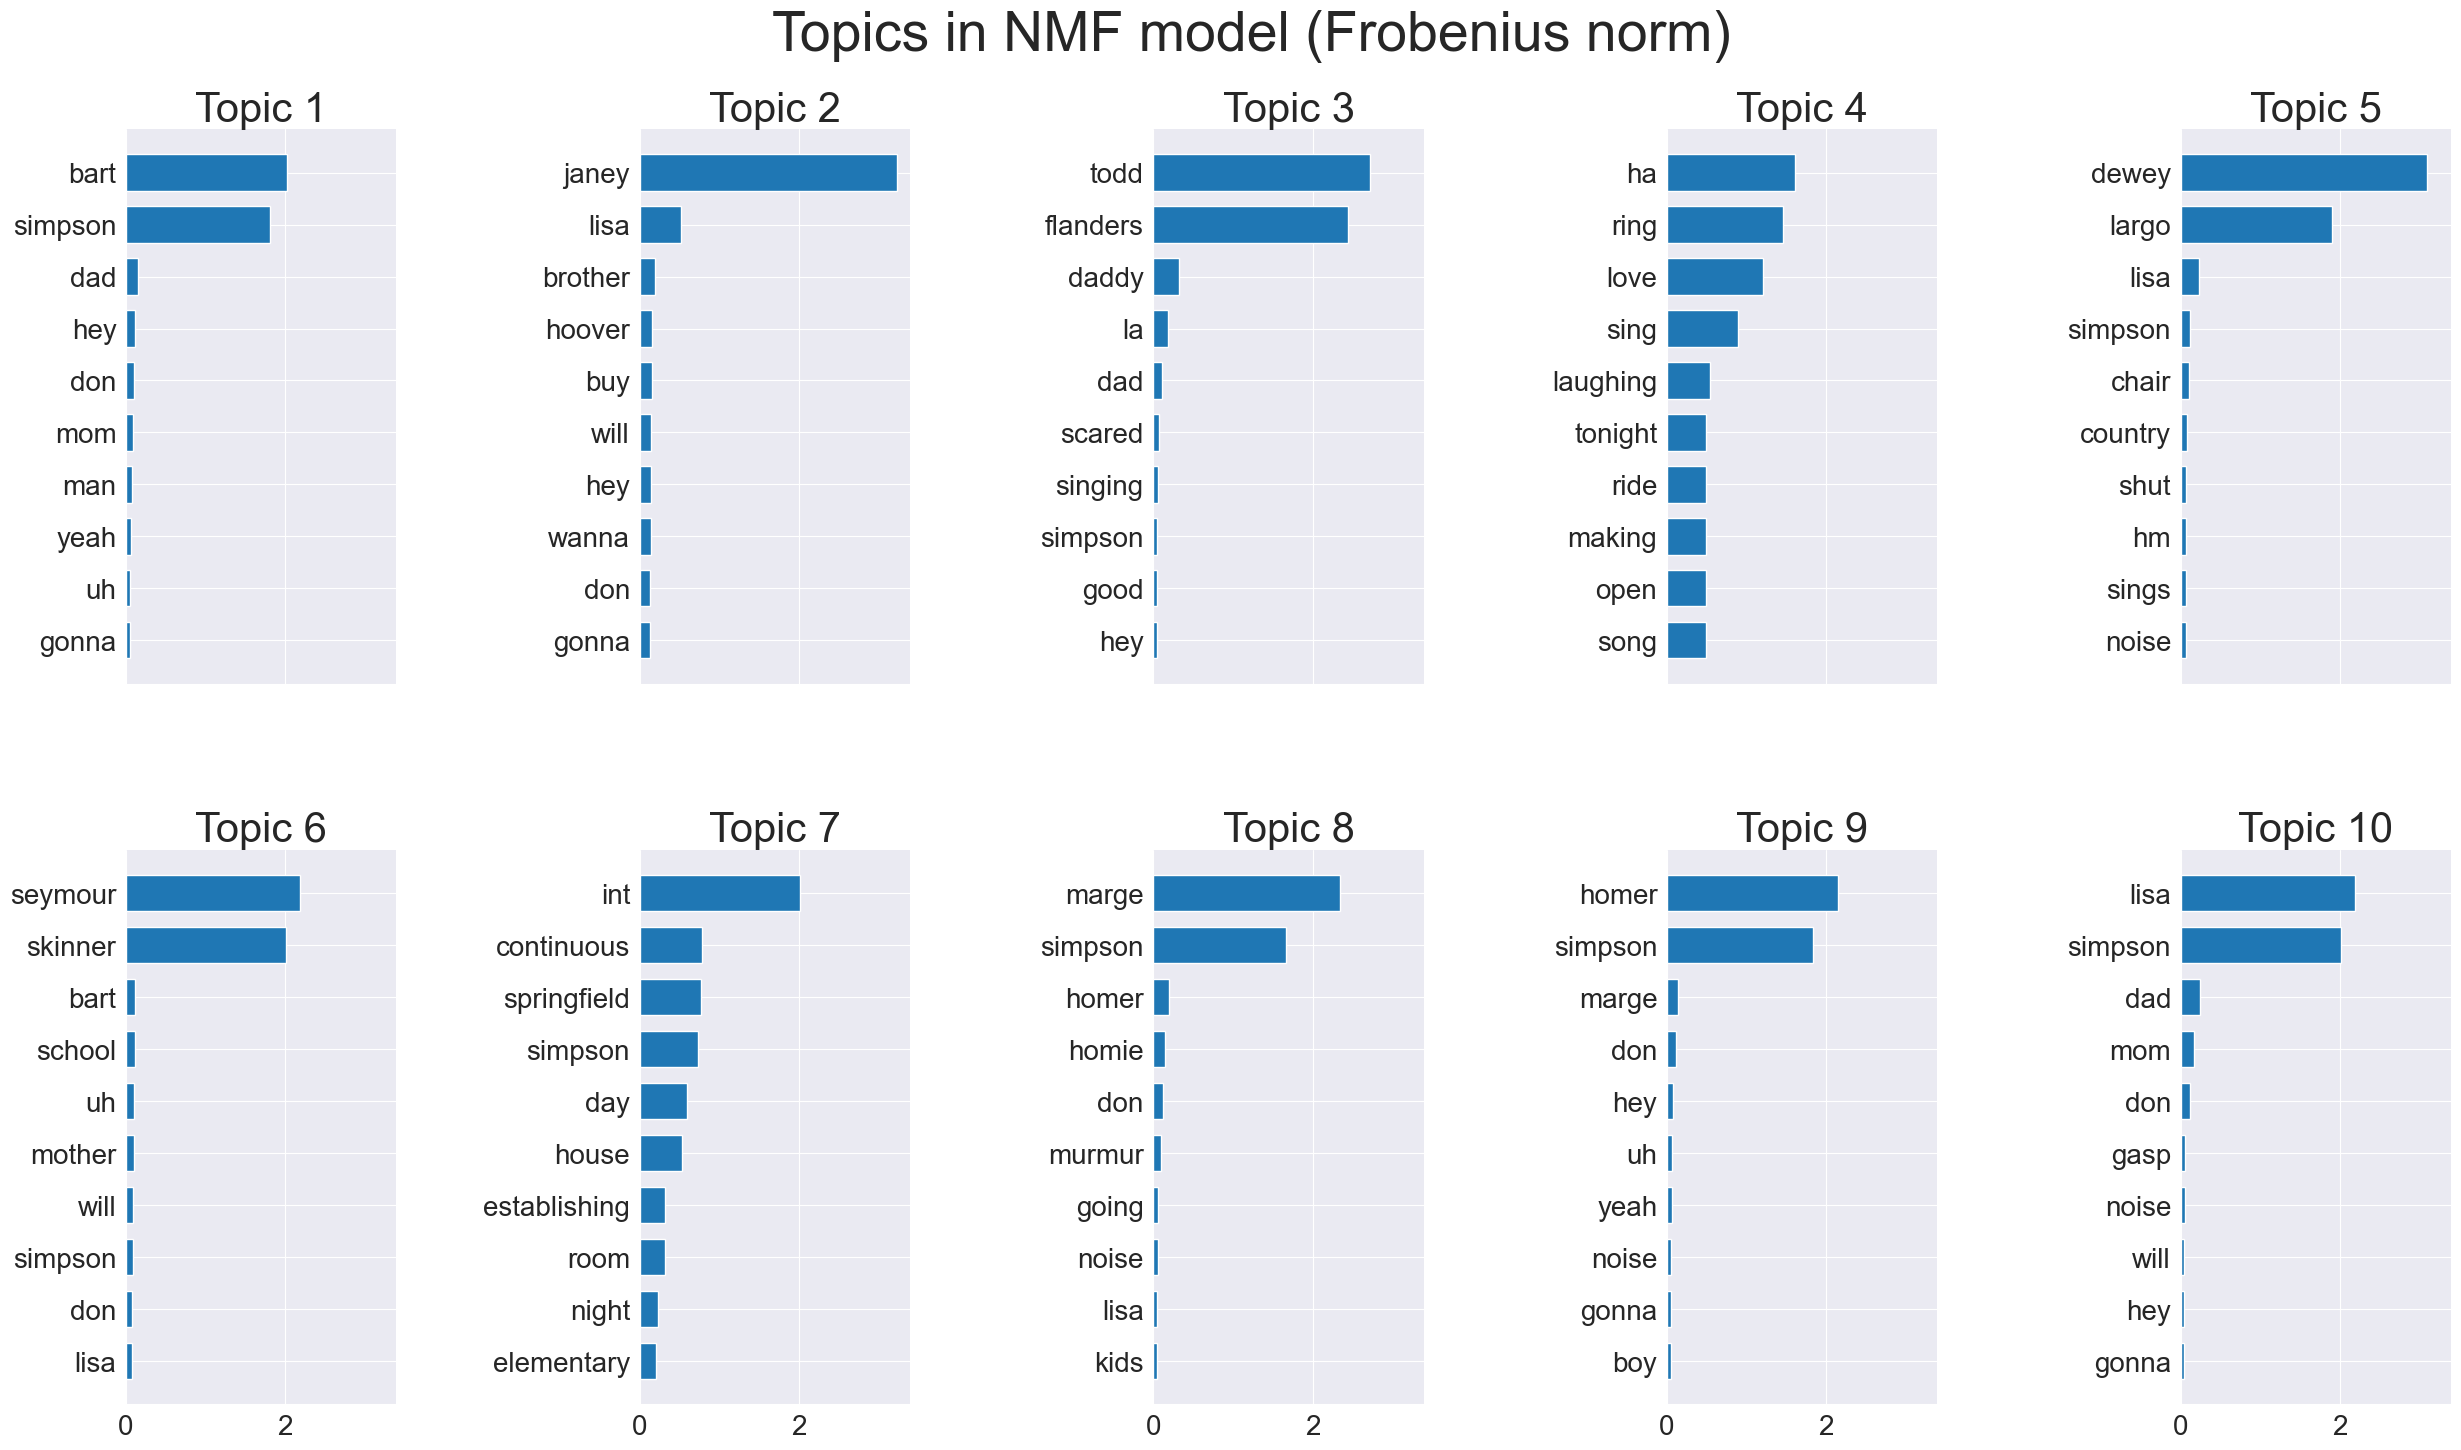

In [159]:
from sklearn.decomposition import NMF
from matplotlib import pyplot as plt


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=1000, stop_words=stopwords_df['stopwords'].tolist()
)

tfidf = tfidf_vectorizer.fit_transform(character_lines)

nmf = NMF(
    n_components=10,
    random_state=1,
    init="nndsvda",
    beta_loss="kullback-leibler",
    solver="mu",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, 10, "Topics in NMF model (Frobenius norm)"
)